<H2>Effects of market movements + liquidity add on LRNA price</H2>
In this notebook, we look at the effects on LRNA price when liquidity is removed during a temporary price move. That is, we set the prices of the assets, then add a large amount of liquidity (doubling the amount of R1 in the pool). We then move the market up or down, then withdraw the liquidity right at the peak of the price move. Finally, we move the market back to where it began and observe the difference in LRNA price between the starting and ending conditions.

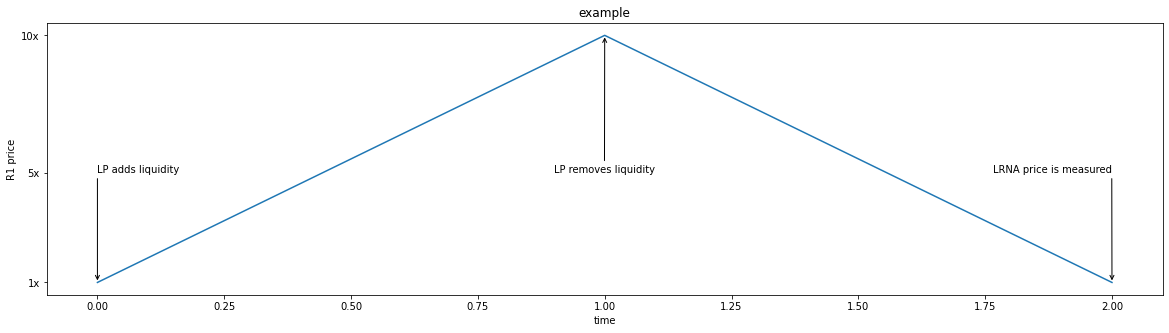

In [1]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.title('example')
plt.xlabel('time')
plt.ylabel('R1 price')
plt.yticks(
    [1, 5, 10],
    ['1x', '5x', '10x']
)
plt.annotate(
    text='LP adds liquidity',
    xy=(0, 1),
    xytext=(0, 5),
    arrowprops={'arrowstyle': '->', 'relpos': (0, 0.5)}
)
plt.annotate(
    text='LP removes liquidity',
    xy=(1, 10),
    xytext=(0.9, 5),
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    text='LRNA price is measured',
    xy=(2, 1),
    xytext=(1.765, 5),
    arrowprops={'arrowstyle': '->', 'relpos': (1, 0.5)}
)
plt.plot([0, 1, 2], [1, 10, 1])


<H3>Changing the degree of price move</H3>
In the first experiment, we set the initial weight of R1 at 5% of the pool, then have the LP add another 5%. We vary the peak price movement from -90% to 10x and then observe the final price of LRNA.

In [2]:
import random
import sys
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, lrna_price, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, withdraw_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from IPython.display import display, Markdown

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.05},
    'USD': {'usd price': 1, 'weight': 0.20},
    'R1': {'usd price': 1, 'weight': 0.05},
    'R2': {'usd price': 2/3, 'weight': 0.70},
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

%matplotlib inline

price_min = 0.1
price_max = 10
steps = 100
price_list = [price_min * ((price_max / price_min) ** (1 / (steps - 1))) ** i for i in range(steps)]
price_moves = {  # {0.1: '-90%', 0.5: '-50%', 2: '2x', 10: '10x'}
    price:
    (
        f"-{round((1 - price) * 100)}%"
        if price < 1 else
        f"{round(price)}x"
    )
    for price in price_list
}

price_move_assets = ['R1']
price_events = []
time_steps = 110

for pump_factor in price_moves:
    for tkn, info in assets.items():
        liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
        lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

    initial_state = GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                lrna_fee=0,
                asset_fee=0
            )
        },
        agents = {
            'Arbitrageur': Agent(
                holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=omnipool_arbitrage(
                    pool_id='omnipool',
                    arb_precision=3
                )
            ),
            'LP': Agent(
                holdings={'R1': liquidity['R1']},
                trade_strategy=invest_all(
                    pool_id='omnipool'
                ) + withdraw_all(time_steps/2)
            )
        },
        evolve_function=historical_prices(price_list=[
            {
                tkn: assets[tkn]['usd price'] * (pump_factor - (abs(i * 2 - (time_steps - 2)) / (time_steps - 2) * (pump_factor - 1)))
                for tkn in price_move_assets
            } 
            for i in range(time_steps - 1)
        ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * 2),
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
    )
    price_events.append([initial_state.copy()] + run.run(initial_state, time_steps=time_steps, silent=True))
    
#     display(Markdown(f"<H3>Omnipool dynamics when liquidity is removed during a temporary price move of {price_moves[pump_factor]}</H3>"))

#     pu.plot(events, asset='all')
#     # plt.figure(figsize=(20, 5))
#     # plt.plot(
#     #     range(time_steps), 
#     #     [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events]
#     # )
#     plt.title('LP holdings value')
#     # pu.plot(events, pool='omnipool', prop='lrna')
#     # pu.plot(events, pool='omnipool', prop='liquidity')
#     # pu.plot(events, pool='omnipool', prop='usd_price', key=['R1', 'R2', 'HDX', 'USD'])
#     plt.figure(figsize=(20, 5))
#     plt.plot(range(len(events)), [1 / x for x in pu.get_datastream(events, pool='omnipool', prop='lrna_price', key='USD')])
#     plt.title("Omnipool USD price of LRNA")
#     plt.annotate(
#         str(f"${lrna_price_usd}"), 
#         xy=(0, 1 / lrna_price(events[0].pools['omnipool'], 'USD')), 
#         xytext=(0,10), 
#         textcoords='offset points'
#     )
#     plt.annotate(
#         str(f"${round(1 / lrna_price(events[-1].pools['omnipool'], 'USD'), 2)}"), 
#         xy=(len(events), 1 / lrna_price(events[-1].pools['omnipool'], 'USD')), 
#         xytext=(-10,10), 
#         textcoords='offset points'
#     )
#     plt.show()

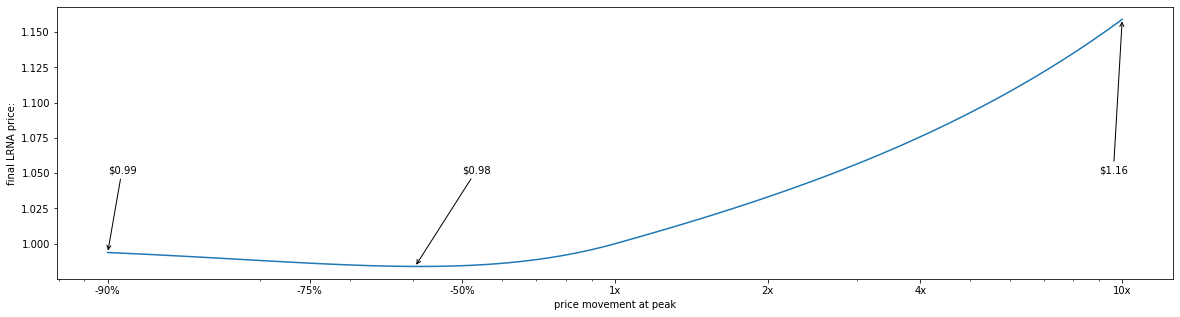

In [3]:
plt.figure(figsize=(20, 5))
plt.xscale('log')
# plt.yscale('log')
plt.xticks(
    [0.1, 0.25, 0.5, 1, 2, 4, 10],
    ['-90%', '-75%', '-50%', '1x', '2x', '4x', '10x']
)
plt.xlabel('price movement at peak')
plt.ylabel('final LRNA price:')

lrna_prices = [1 / lrna_price(events[-1].pools['omnipool'], 'USD') for events in price_events]
plt.annotate(
    xy=(list(price_moves.keys())[lrna_prices.index(min(lrna_prices))], min(lrna_prices)),
    xytext=(0.5, 1.05),
    text=f"${round(min(lrna_prices), 2)}",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    xy=(0.1, lrna_prices[0]),
    xytext=(0.1, 1.05),
    text=f"${round(lrna_prices[0], 2)}",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.annotate(
    xy=(10, lrna_prices[-1]),
    xytext=(9, 1.05),
    text=f"${round(lrna_prices[-1], 2)}",
    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
)
plt.plot(price_moves.keys(), lrna_prices)

<H4>Varying the weight of R1</H4>
In the next experiment, we vary the initial weight of R1 from 0.1% to 10% of the pool, half of which is contributed by a single LP who withdraws at the peak of the price movement. We measure the final price of LRNA as a function of the initial weight of R1 for two cases: a 50% temporary price drop and a 10x price spike.

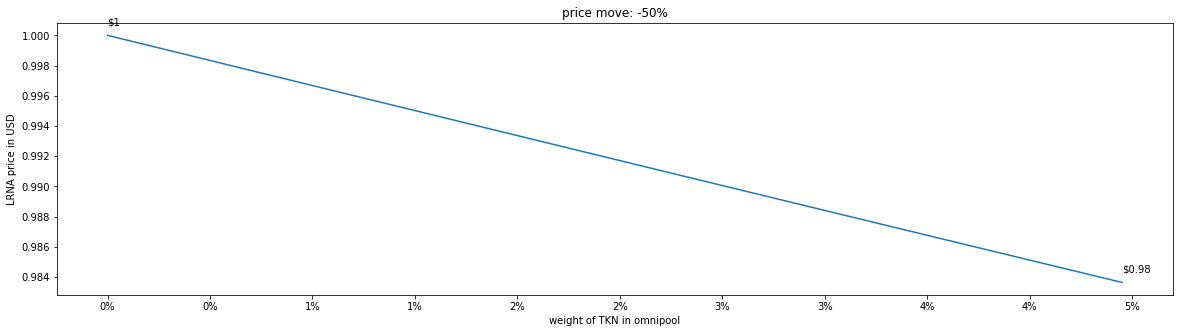

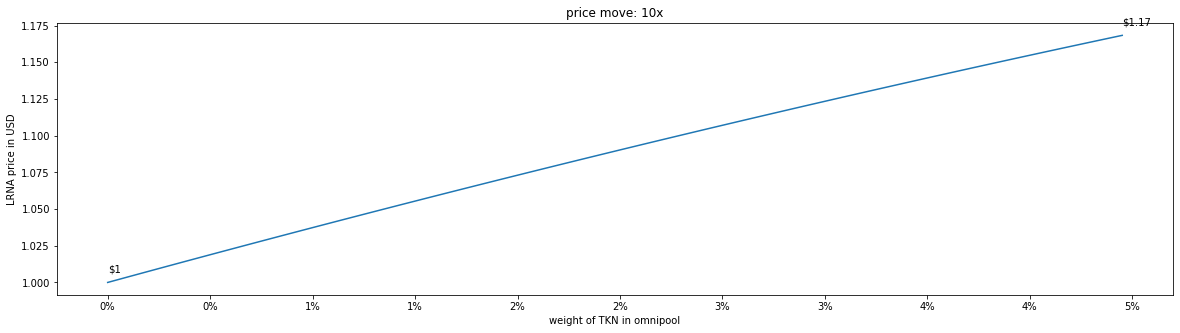

In [4]:
price_moves = {0.5: '-50%', 10: '10x'}
tkn_weights = [0.0005 * i for i in range(1, 102)]
price_move_assets = ['R1']
time_steps = 110
for pump_factor in price_moves:
    events = [initial_state.copy()]
    
    for weight in tkn_weights:
        assets['R1']['weight'] = weight
        assets['R2']['weight'] = 0.75 - (weight * 2)
        # assert round(sum([assets[tkn]['weight'] for tkn in assets]), 10) == 1.0
        
        for tkn, info in assets.items():
            liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
            lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

        initial_state = GlobalState(
            pools={
                'omnipool': OmnipoolState(
                    tokens={
                        tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                    },
                    lrna_fee=0.0005,
                    asset_fee=0.0025
                )
            },
            agents = {
                'Arbitrageur': Agent(
                    holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
                    trade_strategy=omnipool_arbitrage(
                        pool_id='omnipool',
                        arb_precision=1
                    )
                ),
                'LP': Agent(
                    holdings={'R1': liquidity['R1']},
                    trade_strategy=invest_all(
                        pool_id='omnipool'
                    ) + withdraw_all(time_steps/2)
                )
            },
            evolve_function=historical_prices(price_list=[
                {
                    tkn: assets[tkn]['usd price'] * (pump_factor - (abs(i * 2 - (time_steps - 2)) / (time_steps - 2) * (pump_factor - 1)))
                    for tkn in price_move_assets
                } 
                for i in range(time_steps - 1)
            ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * 2),
            external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
        )
        events.append(run.run(initial_state, time_steps=time_steps, silent=True)[-1])
    
    plt.figure(figsize=(20, 5))
    plt.plot(range(len(events)), [1 / x for x in pu.get_datastream(events, pool='omnipool', prop='lrna_price', key='USD')])
    plt.xlabel('weight of TKN in omnipool')
    plt.ylabel('LRNA price in USD')
    ticks_number = len(tkn_weights[::10])
    plt.xticks(
        [1 / (ticks_number - 1) * i * len(events) for i in range(ticks_number)],
        [f'{int(i * 100)}%' for i in tkn_weights[::10]]
    )
    plt.title(f"price move: {price_moves[pump_factor]}")
    plt.annotate(
        str(f"${lrna_price_usd}"), 
        xy=(0, 1 / lrna_price(events[0].pools['omnipool'], 'USD')), 
        xytext=(0,10), 
        textcoords='offset points'
    )
    plt.annotate(
        str(f"${round(1 / lrna_price(events[-1].pools['omnipool'], 'USD'), 2)}"), 
        xy=(len(events), 1 / lrna_price(events[-1].pools['omnipool'], 'USD')), 
        xytext=(-10,10), 
        textcoords='offset points'
    )
    plt.show()

<H4>Varying the percentage of liquidity contributed by LP</H4>
In this experiment, we set the total weight of R1 at 5%, 1-75% of which is contributed by a single LP who then withdraws it at the peak of the price move. We measure the final price of LRNA as a function of the contribution from the LP for the same two cases: -50% and 10x. 

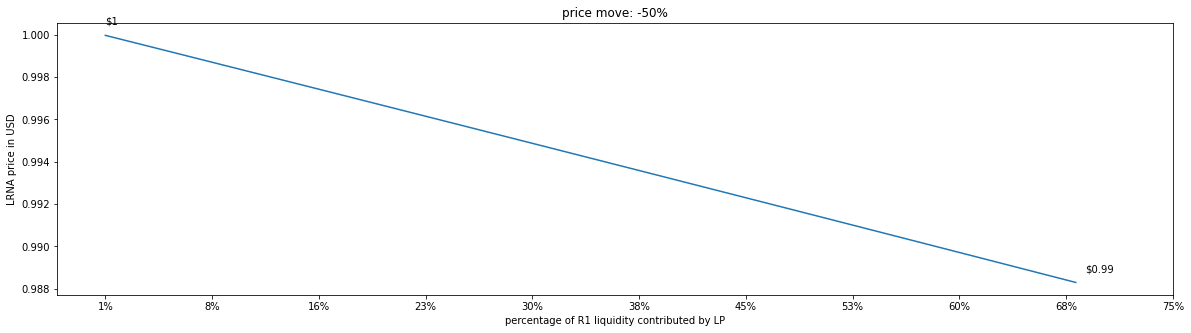

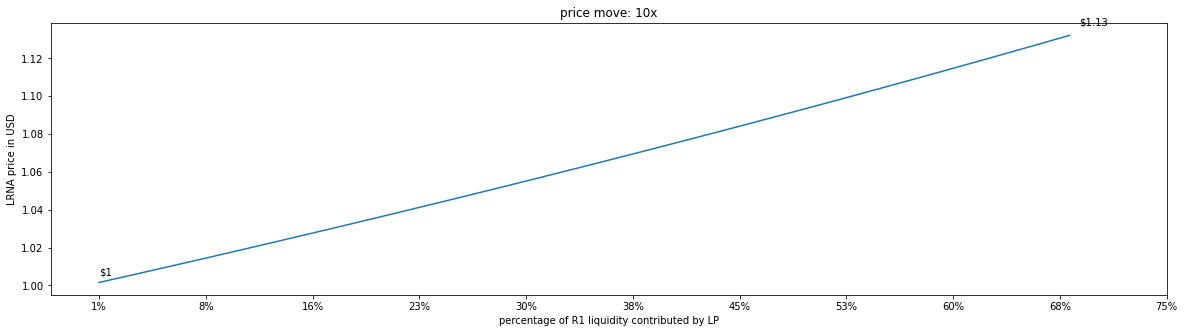

In [5]:
price_moves = {0.5: '-50%', 10: '10x'}
weight = 0.05
lp_percent = [0.00742574257 * i for i in range(1, 102)]
price_move_assets = ['R1']
time_steps = 110
lp_events = {}
for pump_factor in price_moves:
    lp_events[pump_factor] = []
    for percent in lp_percent:
        assets['R1']['weight'] = weight * (1 - percent)
        assets['R2']['weight'] = 0.75  # - weight * (1 - percent)
        # assert round(sum([assets[tkn]['weight'] for tkn in assets]), 10) == 1.0
        
        for tkn, info in assets.items():
            liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
            lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

        initial_state = GlobalState(
            pools={
                'omnipool': OmnipoolState(
                    tokens={
                        tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                    },
                    lrna_fee=0.0005,
                    asset_fee=0.0025
                )
            },
            agents = {
                'Arbitrageur': Agent(
                    holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
                    trade_strategy=omnipool_arbitrage(
                        pool_id='omnipool',
                        arb_precision=1
                    )
                ),
                'LP': Agent(
                    holdings={'R1': initial_omnipool_tvl * weight * percent},
                    trade_strategy=invest_all(
                        pool_id='omnipool'
                    ) + withdraw_all(time_steps/2)
                )
            },
            evolve_function=historical_prices(price_list=[
                {
                    tkn: assets[tkn]['usd price'] * (pump_factor - (abs(i * 2 - (time_steps - 2)) / (time_steps - 2) * (pump_factor - 1)))
                    for tkn in price_move_assets
                } 
                for i in range(time_steps - 1)
            ] + [{tkn: assets[tkn]['usd price'] for tkn in price_move_assets}] * 2),
            external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
        )
        lp_events[pump_factor].append(run.run(initial_state, time_steps=time_steps, silent=True))
    
    plt.figure(figsize=(20, 5))
    plt.plot([1 / x for x in pu.get_datastream([events[-1] for events in lp_events[pump_factor]], pool='omnipool', prop='lrna_price', key='USD')])
    plt.xlabel('percentage of R1 liquidity contributed by LP')
    plt.ylabel('LRNA price in USD')
    ticks_number = len(lp_percent[::10])
    plt.xticks(
        [1 / (ticks_number - 1) * i * time_steps for i in range(ticks_number)],
        [f'{round(i * 100)}%' for i in lp_percent[::10]]
    )
    plt.title(f"price move: {price_moves[pump_factor]}")
    plt.annotate(
        str(f"${lrna_price_usd}"), 
        xy=(0, 1 / lrna_price(initial_state.pools['omnipool'], 'USD')), 
        xytext=(0,10), 
        textcoords='offset points'
    )
    plt.annotate(
        str(f"${round(1 / lrna_price(lp_events[pump_factor][-1][-1].pools['omnipool'], 'USD'), 2)}"), 
        xy=(len(events), 1 / lrna_price(lp_events[pump_factor][-1][-1].pools['omnipool'], 'USD')), 
        xytext=(-10,10), 
        textcoords='offset points'
    )
    plt.show()